<a href="https://colab.research.google.com/github/tillu1208/OpenCV/blob/main/15_02_Object_Detection_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:30px;">Object Detection using YOLOv4</h1>

In this module, we will learn how to use YOLOv4 — a state of the art object detector — with OpenCV.

YOLOv4 is the latest variant of a popular object detection algorithm **YOLO – You Only Look Once**. The published model recognizes 80 different objects in images and videos, but most importantly it is fast and very accurate.

In [1]:
if 'google.colab' in str(get_ipython()):
    print("Downloading Code to Colab Environment")
    !wget https://www.dropbox.com/sh/uro596fmm67in3b/AABurDoQj5tS94EgUDQXkcBaa?dl=1 -O module-code.zip -q --show-progress
    !unzip -qq module-code.zip
    !pip install --upgrade opencv-python
else:
    pass

module-code.zip     100%[===================>] 141.18M  95.1MB/s    in 1.5s    
mapname:  conversion of  failed
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 5.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76


In [2]:
import numpy as np
import cv2
import sys
import requests
from os import path

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0,15.0)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14

# 1. Learning about YOLO

## <font style="color:rgb(50,120,229)">What it means to "Only Look Once"</font>

Compared to other neural networks, YOLO is unique because it detects objects by looking at the overall scene (image or video) as a whole, instead of analyzing individual regions at a time. This results in some level of tradeoff for speed over precision. Despite this, YOLO is one of the most powerful realtime object detection architectures today, and is ideal to power the vision behind driverless cars.

When trained, YOLO learns a generalized representation of the class of objects - meaning it is likely to perform well when presented with an unfamiliar representation of the object (shadowed, eclipsed, etc), and not get thrown off when there are other unexpected objects in the scene. This is because, by definition, it was trained to identify objects when considering the scene has a whole.

## <font style="color:rgb(50,120,229)">Why use YOLO with OpenCV?</font>
Here are a few reasons you may want to use OpenCV for YOLO:

1. **Easy integration with an OpenCV application:** If your application already uses OpenCV and you simply want to use YOLOv4, you don’t have to worry about compiling and building the extra Darknet code.
2. **OpenCV CPU version is 9x faster:** OpenCV’s CPU implementation of the DNN module is astonishingly fast. For example, Darknet when used with OpenMP takes about 2 seconds on a CPU for inference on a single image. In contrast, OpenCV’s implementation runs in a mere 0.22 seconds! Check out table below.
3. **Python support:** Darknet is written in C, and it does not officially support Python. In contrast, OpenCV does. There are python ports available for Darknet though.


# 2. Object Detection using YOLOv4 in OpenCV
Let us now see how to use YOLOv4 in OpenCV to perform object detection.

## 2.1: Initialize the parameters
The YOLOv4 algorithm generates bounding boxes as the predicted detection outputs. Every predicted box is associated with a confidence score. In the first stage, all the boxes below the confidence threshold parameter are ignored for further processing.

The rest of the boxes undergo non-maximum suppression which removes redundant overlapping bounding boxes. **Non-maximum suppression** is controlled by a parameter **nmsThreshold**. You can try to change these values and see how the number of output predicted boxes changes.

Next, the default values for the input width (**inpWidth**) and height (**inpHeight**) for the network’s input image are set. We set each of them to 416, so that we can compare our runs to the Darknet’s C code given by YOLOv4’s authors. You can also change both of them to 320 to get faster results or to 608 to get more accurate results.


In [ ]:
# Initialize the parameters
objectnessThreshold = 0.5 # Objectness threshold, high values filter out low objectness
confThreshold = 0.5       # Confidence threshold, high values filter out low confidence detections
nmsThreshold = 0.4        # Non-maximum suppression threshold, higher values result in duplicate boxes per object
inpWidth = 416            # Width of network's input image, larger is slower but more accurate
inpHeight = 416           # Height of network's input image, larger is slower but more accurate

## 2.2: Load the model and classes
The file **coco.names** contains all the objects for which the model was trained. We read class names.

Next, we load the network which has two parts —

- **yolov4.weights :** The pre-trained weights.
- **yolov4.cfg :** The configuration file.

We set the DNN backend to OpenCV here and the target to CPU. You could try setting the preferable target to **cv.dnn.DNN_TARGET_OPENCL** to run it on a GPU. But keep in mind that the current OpenCV version is tested only with Intel’s GPUs, and would automatically switch to CPU if you do not have an Intel GPU.

Other models can be downloaded from this repo: https://github.com/AlexeyAB/darknet

In [ ]:
# Load names of classes.
classesFile = "coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "yolov4.cfg"
modelWeights = "yolov4.weights"

if(not path.exists(modelWeights)):

    url = "https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights"

    r = requests.get(url)

    print('Downloading YOLO v4 Model.......')

    with open(modelWeights, 'wb') as f:
        f.write(r.content)

    print('\nyolov4.weights Download complete!')



yolov4.weights Download complete!


In [ ]:
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)

## 2.3: Process each frame
The input image is passed through the network and the output is decoded and displayed using a few utility functions. Let us go over the utility functions.

### <font style="color:rgb(50,120,230)">2.3.1: Getting the names of output layers</font>
The **forward** function in OpenCV’s Net class needs to know until which layer the blob should be passed through the network. Since we want to run through the whole network, we need to identify the last layer of the network. We do that by using the function **getUnconnectedOutLayers()** that gives the names of the unconnected output layers, which are essentially the last layers of the network. After this, we would then we run the forward pass of the network to get output from the output layers like: **net.forward(getOutputsNames(net))**.


In [ ]:
def getOutputsNames(net):
    """Get the names of all output layers in the network."""
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i - 1] for i in net.getUnconnectedOutLayers()]

### <font style="color:rgb(50,120,230)">2.3.2: Post-processing the network’s output</font>
The network outputs bounding boxes are each represented by a vector of number of classes + 5 elements.

The first 4 elements represent the **center_x**, **center_y**, **width** and **height**. The fifth element represents the confidence that the bounding box encloses an object.

The rest of the elements are the confidence associated with each class (i.e. object type). The box itself is assigned to the class corresponding to the highest score.

The highest score for a box is also called its **confidence**. If the confidence of a box is less than the given threshold, the bounding box is dropped and not considered for further processing.

The boxes with their confidence equal to or greater than the confidence threshold are then subjected to Non Maximum Suppression. This would reduce the number of overlapping boxes.


In [ ]:
FONTFACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
THICKNESS = 1


def display_objects(frame, outs):
    """Remove the bounding boxes with low confidence using non-maxima suppression."""
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []

    # Loop through all outputs.
    for out in outs:
        for detection in out:
            if detection[4] > objectnessThreshold:
                scores = detection[5:]
                classId = np.argmax(scores)
                confidence = scores[classId]
                if confidence > confThreshold:
                    center_x = int(detection[0] * frameWidth)
                    center_y = int(detection[1] * frameHeight)
                    width = int(detection[2] * frameWidth)
                    height = int(detection[3] * frameHeight)

                    left = int(center_x - width / 2)
                    top = int(center_y - height / 2)
                    classIds.append(classId)
                    confidences.append(float(confidence))
                    boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        cv2.rectangle(frame, (left, top), (left + width, top + height), (255, 255, 255), 2)
        label = "{}:{:.2f}".format(classes[classIds[i]], confidences[i])
        display_text(frame, label, left, top)

The Non Maximum Suppression is controlled by the nmsThreshold parameter. If nmsThreshold is set too low, e.g. 0.1, we might not detect overlapping objects of same or different classes. But if it is set too high e.g. 1, then we get multiple boxes for the same object. So we used an intermediate value of 0.4 in our code above. The gif below shows the effect of varying the NMS threshold.

<br>
<center>
<a href="https://courses.opencv.org/asset-v1:OpenCV+101+Beginners+type@asset+block@nms-car.gif"><img src="https://courses.opencv.org/asset-v1:OpenCV+101+Beginners+type@asset+block@nms-car.gif"/> </a>
</center>
<br>

<center>non maximum suppression threshold object detection</center>

### <font style="color:rgb(50,120,230)">2.3.3: Display text</font>

This is just a utility function used for displaying the object class Name on the image.

In [ ]:
def display_text(im, text, x, y):
    """Draw text onto image at location."""

    # Get text size
    textSize = cv2.getTextSize(text, FONTFACE, FONT_SCALE, THICKNESS)
    dim = textSize[0]
    baseline = textSize[1]

    # Use text size to create a black rectangle.
    cv2.rectangle(im, (x,y), (x + dim[0], y + dim[1] + baseline), (0,0,0), cv2.FILLED);
    # Display text inside the rectangle.
    cv2.putText(im, text, (x, y + dim[1]), FONTFACE, FONT_SCALE, (0, 255, 255), THICKNESS, cv2.LINE_AA)


# 3. The main loop
After a frame is read from the input image or video stream, it is passed through the **blobFromImage** function to convert it to an **input blob** for the neural network. In this process, it scales the image pixel values to a target range of 0 to 1 using a scale factor of 1/255. It also resizes the image to the given size of (416, 416) without cropping. Note that we do not perform any mean subtraction here, hence pass [0,0,0] to the mean parameter of the function and keep the swapRB parameter to its default value of 1.

The output blob is then passed in to the network as its input and a forward pass is run to get a list of predicted bounding boxes as the network’s output. These boxes go through a post-processing step in order to filter out the ones with low confidence scores. We will go through the post-processing step in more detail in the next section. We print out the inference time for each frame at the top left. The image with the final bounding boxes is then saved to the disk, either as an image for an image input or using a video writer for the input video stream.


## 3.1 Inference using Yolo v4

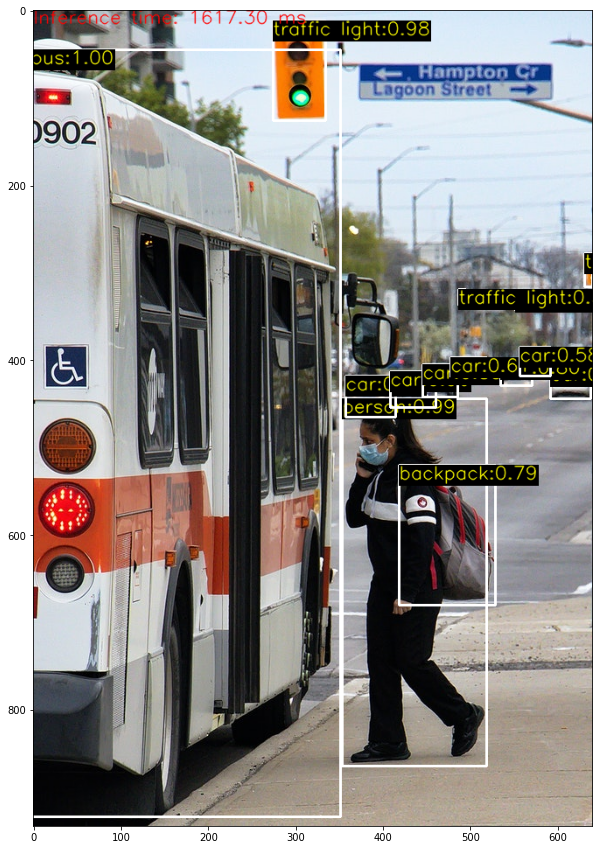

Inference time: 1617.30 ms


In [ ]:
# Process inputs
imagePath = "traffic.jpg"
frame = cv2.imread(imagePath)

# Create a 4D blob from a frame.
blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

# Sets the input to the network
net.setInput(blob)

# Runs the forward pass to get output of the output layers
outs = net.forward(getOutputsNames(net))

# Remove the bounding boxes with low confidence
display_objects(frame, outs)

# Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1, cv2.LINE_AA)
plt.imshow(frame[..., ::-1])
plt.show()
print(label)

## 3.2 Inference using YOLO v4 Tiny

Now let's compare to YOLO v4 Tiny, where the same architecture is used but where the network size is substantially reduced.

### <font style="color:rgb(50,120,229)">Download the tiny model and load in memory</font>

In [ ]:
tiny_modelConfiguration = "yolov4-tiny.cfg"
tiny_modelWeights = "yolov4-tiny.weights"


if(not path.exists(tiny_modelWeights)):

    url = "https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights"

    r = requests.get(url)

    print('Downloading YOLO v4 Tiny Model.......')

    with open(tiny_modelWeights, 'wb') as f:
        f.write(r.content)

    print('\nyolov4-tiny.weights Download complete!!')
net_tiny = cv2.dnn.readNetFromDarknet(tiny_modelConfiguration, tiny_modelWeights)


### <font style="color:rgb(50,120,229)"> Process input</font>

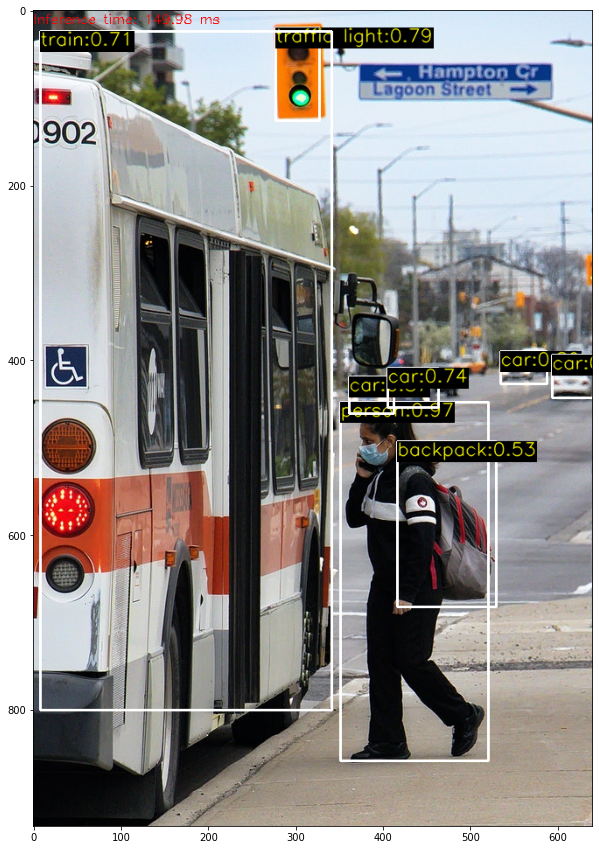

Inference time: 149.98 ms


In [ ]:
# Process inputs
imagePath = "traffic.jpg"
frame = cv2.imread(imagePath)

# Create a 4D blob from a frame.
blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0, 0, 0], 1, crop=False)

# Sets the input to the network
net_tiny.setInput(blob)

# Runs the forward pass to get output of the output layers
outs = net_tiny.forward(getOutputsNames(net_tiny))

# Remove the bounding boxes with low confidence
display_objects(frame, outs)

# Put efficiency information. The function getPerfProfile returns the overall time for
# inference(t) and the timings for each of the layers(in layersTimes).
t, _ = net_tiny.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

plt.imshow(frame[..., ::-1])
plt.show()
print(label)

Notice the difference in inference times in the two models. YOLO v4 Tiny is nearly an order of magnitude faster in this scenario. For instance, 50ms would correspond to over around 20 frames per second, while 500 would be closer to 2 frames per second (much slower).